# P3: OpenStreetMap Data Case Study. Moscow Region

### 0.1. Code Library

In [1]:
from ipykernel import kernelapp as app

In [2]:
from IPython.core.display import display, HTML

In [3]:
import matplotlib

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
import folium

In [7]:
import geopandas as gpd

In [8]:
from mpl_toolkits.basemap import Basemap

In [9]:
import xml.etree.cElementTree as ET

In [10]:
from collections import defaultdict as dfdict

In [11]:
import numpy as np

In [12]:
import pprint

In [13]:
import urllib

In [14]:
import re

In [15]:
import os

In [22]:
import csv

In [26]:
import cerberus

In [16]:
from IPython.display import Image

In [17]:
import collections

In [18]:
import sqlite3

In [19]:
import geopandas.io

In [20]:
from sqlalchemy import create_engine

In [21]:
import pandas as pd

In [23]:
import json

In [24]:
import io

In [25]:
import codecs

In [27]:
from string import Template

### 0.2. Useful links

https://wiki.openstreetmap.org/wiki/OSM_XML

https://mapzen.com/data/metro-extracts/

http://python-visualization.github.io/folium/quickstart.html

http://geopandas.org/mapping.html

https://borealperspectives.wordpress.com/2016/03/07/plotting-polygon-shapefiles-on-a-matplotlib-basemap-with-geopandas-shapely-and-descartes/

http://maxberggren.se/2015/08/04/basemap/

### 0.3. Code for Researching the Imported Files and Creating the Data.

##### Сode snippets of the courses "Intro to Relational Databases", "Data Wrangling with MongoDB" (udacity.com) have been used here.

In [28]:
# Function for counting tags.
def count_tags(filename):
    count = dfdict(int)
    for item in ET.iterparse(filename):
        count[item[1].tag] += 1
    return count

In [29]:
# Functions for counting users.
def get_user(element):
    return

def process_map_users(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        if element.tag == 'node' or element.tag == 'way' or element.tag == 'relation':
            users.add(element.attrib['user'])

    return users

In [95]:
# Strings containing lower case chars
lower = re.compile(r'^([a-z]|_)*$') 
# Strings with lower case chars and a ':'
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
# Strings with chars that will cause problems as keys. 
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')  

# Function for sorting by key type.
def key_type(element, keys):
    if element.tag == "tag":

            if lower.search(element.attrib['k']) != None: 
                keys['lower'] += 1
            elif lower_colon.search(element.attrib['k']) != None:
                keys['lower_colon'] += 1
            elif problemchars.search(element.attrib['k']) != None:
                keys['problemchars'] += 1
            else: 
                keys['other'] += 1

    return keys

# Function for counting keys by type.
def process_map_keys(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

In [31]:
# Function for counting street addresses.
def street_number(file_name):
    count = 0

    for event, elem in ET.iterparse(file_name, events=("start",)):
        if elem.tag == 'node' or elem.tag == 'way':
            for tag in elem.iter('tag'):
                if tag.attrib['k'] == "addr:street":
                    count += 1
    return count

In [32]:
# Function for counting zip codes.
def zip_codes(filename):
    count = 0
    data = set()

    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag == 'node' or elem.tag == 'way':
            for tag in elem.iter('tag'):
                if tag.attrib['k'] == "addr:postcode":
                    count += 1
                    data.add( tag.attrib['v'] )
                                     
    return count, data

In [109]:
# Functions for auditing zip codes.
expected=list(range(140000,143000) + range(144000, 145000) + range(600000, 603000))
map(str, expected)

def audit_postcode_range(postcode,tag):
    if tag.attrib["v"] not in expected:
        if tag.attrib["v"] not in postcode:
            postcode[tag.attrib["v"]]=1
        else:
            postcode[tag.attrib["v"]]+=1    
            
def is_postcode(elem):
    return (elem.attrib['k'] == "addr:postcode")

def process_map_postcodes(filename):
    postcode={}
    osm_file = open(filename, "r")
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_postcode(tag):
                    audit_postcode_range(postcode,tag)
    return postcode   

In [118]:
# Function for displaying english names.
def process_map_names(filename):
    count = 0
    data = set()

    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag == 'node' or elem.tag == 'way':
            for tag in elem.iter('tag'):
                if tag.attrib['k'] == "name:en":
                    count += 1
                    data.add( tag.attrib['v'] )
                                     
    return count, data 

In [147]:
# Function for sorting by place.
def place_type(element, places):
    if element.tag == "node":
         for tag in element.iter('tag'):
                if tag.attrib['k'] == 'place':
                    if tag.attrib['v'] == 'city': 
                        places['city'] += 1
                    elif tag.attrib['v'] == 'town':
                        places['town'] += 1
                    elif tag.attrib['v'] == 'village':
                        places['village'] += 1
                    elif tag.attrib['v'] == 'hamlet':
                        places['hamlet'] += 1
                    else: 
                        places['other'] += 1
                        
    return places

# Function for counting places by type.
def process_map_places(filename):
    places = {"city": 0, "town": 0, "village": 0, "hamlet" : 0, "other": 0}
    for _, element in ET.iterparse(filename):
        places = place_type(element, places)

    return places

In [165]:
# Functions for creating the sample file
k = 100 # Parameter: take every k-th top level element

def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write('</osm>')

In [161]:
# Schema for validating elements
schema1 = {
    'node': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'lat': {'required': True, 'type': 'float', 'coerce': float},
            'lon': {'required': True, 'type': 'float', 'coerce': float},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'node_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    },
    'way': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'way_nodes': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'node_id': {'required': True, 'type': 'integer', 'coerce': int},
                'position': {'required': True, 'type': 'integer', 'coerce': int}
            }
        }
    },
    'way_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string', 'required': True}
            }
        }
    }
}


In [162]:
LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')


# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['changeset', 'id', 'timestamp', 'uid', 'user', 'version']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS, 
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    if element.tag == 'node':
        node_attributes = {}    
        tags = []
        
        for unit in NODE_FIELDS:
            node_attributes[unit] = element.attrib[unit]

        for tag in element.iter('tag'):  
 
            problem = PROBLEMCHARS.search(tag.attrib['k'])

            if not problem:
                node_tag_dictionary = {} 
                node_tag_dictionary['id'] = element.attrib['id'] 
                node_tag_dictionary['value'] = tag.attrib['v']  

                point = LOWER_COLON.search(tag.attrib['k'])
                if not point:
                    node_tag_dictionary['type'] = 'regular'
                    node_tag_dictionary['key'] = tag.attrib['k']
                else:
                    before = re.findall('^(.+):', tag.attrib['k'])
                    after = re.findall('^[a-z]+:(.+)', tag.attrib['k'])

                    node_tag_dictionary['type'] = before[0]
                    node_tag_dictionary['key'] = after[0]

            tags.append(node_tag_dictionary)
        
        return {'node': node_attributes, 'node_tags': tags}
    
    elif element.tag == 'way':
        way_attributes = {}
        way_nodes = []
        tags = []  
    
        for unit in WAY_FIELDS:
            way_attributes[unit] = element.attrib[unit]
    
        for tag in element.iter('tag'):  
 
            problem = PROBLEMCHARS.search(tag.attrib['k'])
            if not problem:
                way_tag_dictionary = {}
                way_tag_dictionary['id'] = element.attrib['id'] 
                way_tag_dictionary['value'] = tag.attrib['v']  

                point = LOWER_COLON.search(tag.attrib['k'])
                if not point:
                    way_tag_dictionary['type'] = 'regular'
                    way_tag_dictionary['key'] = tag.attrib['k']
                else:
                    before = re.findall('^(.+):', tag.attrib['k'])
                    after = re.findall('^[a-z]+:(.+)', tag.attrib['k'])

                    way_tag_dictionary['type'] = before[0]
                    way_tag_dictionary['key'] = after[0]

            tags.append(way_tag_dictionary)
    
        for tag in element.iter("nd"):  
            way_nd_dictionary = {} 
            count = 0
            way_nd_dictionary['id'] = element.attrib['id'] 
            way_nd_dictionary['node_id'] = tag.attrib['ref'] 
            way_nd_dictionary['position'] = count  
            count += 1
            
            way_nodes.append(way_nd_dictionary)
    
        return {'way': way_attributes, 'way_nodes': way_nodes, 'way_tags': tags}
# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=schema1):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_strings = (
            "{0}: {1}".format(k, v if isinstance(v, str) else ", ".join(v))
            for k, v in errors.iteritems()
        )
        raise cerberus.ValidationError(
            message_string.format(field, "\n".join(error_strings))
        )


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map_csv(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
        codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
        codecs.open(WAYS_PATH, 'w') as ways_file, \
        codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
        codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


# if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.

In [163]:
# Strings containing lower case chars
lower = re.compile(r'^([a-z]|_)*$')
# Strings with lower case chars and a ':'
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
# Strings with chars that will cause problems as keys.
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]

# Function for checking the presence of addresses.
def is_address(elem):
    if elem.attrib['k'][:5] == "addr:":
        return True
# Function for creating nodes.
def shape_element(element):
    node = {}
    if element.tag == "node" or element.tag == "way":
        address_info = {}
        nd_info = []
        #pprint.pprint(element.attrib)
        node["type"] = element.tag
        node["id"] = element.attrib["id"]
        if "visible" in element.attrib.keys():
            node["visible"] = element.attrib["visible"]
        if "lat" in element.attrib.keys():
            node["pos"] = [float(element.attrib['lat']), float(element.attrib['lon'])]
        node["created"] = {"version": element.attrib['version'],
                            "changeset": element.attrib['changeset'],
                            "timestamp": element.attrib['timestamp'],
                            "uid": element.attrib['uid'],
                            "user": element.attrib['user']}
        for tag in element.iter("tag"):
            #print tag.attrib
            p = problemchars.search(tag.attrib['k'])
            if p:
                #print "PROBLEM:", p.group()
                continue
            elif is_address(tag):
                if ":" in tag.attrib['k'][5:]:
                    #print "Bad Address:", tag.attrib['k'], "--", tag.attrib['v']
                    continue
                else:
                    address_info[tag.attrib['k'][5:]] = tag.attrib['v']
                    #print "Good Address:", tag.attrib['k'], "--", tag.attrib['v']
            else:
                node[tag.attrib['k']] = tag.attrib['v']
                #print "Outside:", tag.attrib['k'], "--", tag.attrib['v']
        if address_info != {}:
            node['address'] = address_info
        for tag2 in element.iter("nd"):
            nd_info.append(tag2.attrib['ref'])
            #print tag2.attrib['ref']
        if nd_info != []:
            node['node_refs'] = nd_info
        return node
    else:
        return None
# Function for creating the .json file
def process_map(file_in, pretty = False):
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

### 1. Map Area

#### 1.1.  The map
##### I have chosed the map sector of the dynamically developing area in the Moscow region, Russia.
##### For displaying the area I have used the  package "folium" and the coordinates of this area in moscow_region.osm.

In [39]:
# Display the coordinates of bounds from .osm file
HTML('<h4>bounds minlat="55.5037498" minlon="38.3944702" maxlat="56.1011515" maxlon="39.5617675"</h4>')

In [159]:
# Setup the coordinates of the map center and the zoom option.
map_osm = folium.Map(location=[55.7986, 38.9754], zoom_start=9)
# Add labels with coordinates.
folium.LatLngPopup().add_to(map_osm)
# Setup the coordinates of the map area.
points=[[55.5037, 38.3945], [55.5037, 39.5618], [56.1012, 39.5618], [56.1012, 38.3945], [55.5037, 38.3945]]
# Setup the border line with options.
folium.PolyLine(points, color="red", weight=5, opacity=0.3).add_to(map_osm)
# Display the map.
map_osm

##### 1.2 Extract with Python
##### There are several ways to extract geodata. One of them is to do this with this python code cell.

In [166]:
# Extract from overpass-api.de
file00 = urllib.URLopener()
file00.retrieve("http://overpass-api.de/api/map? bbox=38.3945,55.5037,39.5618,56.1012", "moscow_region0.osm")

('moscow_region0.osm', <httplib.HTTPMessage instance at 0x198052d40>)

##### 1.3 Extract from OpenStreetMaps.org

##### Another possible way is extracting data files in many different formats from the website: 
https://mapzen.com/data/metro-extracts/ .
##### The files moscow_region.osm, moscow_region_buildings.geojson, etc.  were downloaded.

#### 1.4. Size of downloaded files.

In [167]:
# Setup file directories and names of file variables
filedir1 = '/Users/olgabelitskaya/projects/nd002/Data_Analyst_ND_Project3/'
filedir2 = '/Users/olgabelitskaya/projects/nd002/Data_Analyst_ND_Project3/moscow_region.imposm-geojson/'
filedir3 = '/Users/olgabelitskaya/projects/nd002/Data_Analyst_ND_Project3/moscow_region.imposm-shapefiles/'
file0 = filedir1 + 'moscow_region0.osm'
file1 = filedir1 + 'moscow_region.osm'
file2 = filedir2 + 'moscow_region_admin.geojson'
file3 = filedir2 + 'moscow_region_roads.geojson'
file4 = filedir2 + 'moscow_region_waterareas.geojson'
file5 = filedir1 + 'sample.osm'

In [168]:
# Get size of the .osm files
os.path.getsize(file0)

251766924

In [89]:
os.path.getsize(file1)

239613812

In [45]:
# Get size of the .geojson files
os.path.getsize(file2)

418743

In [46]:
os.path.getsize(file3)

20282370

In [47]:
os.path.getsize(file4)

3727423

In [48]:
os.path.getsize(file5)

2425559

##### 1.5 Osm files

##### This is not so large piece of data to process (239,6 MB) in the moscow_region .osm file and for me it is a very interesting subject for reseach because of many reasons.
##### For example, it is a constant changing territory and there is my hometown here.
##### Applying the special function (§ 0.3) I created the sample.osm file from the moscow_region .osm file.

In [164]:
# Setup the file for sample extraction
OSM_FILE = file1 
# Setup the name for the file with a sample
SAMPLE_FILE = "sample.osm"

#### 1.6 Geojson files
##### It's possible to download from OpenStreetMap several type of files: .osm, .geojson, etc.
##### For displaying the data in .geojson files the  package "geopandas" also can be useful. As an example you can see the map of administrative borders, roads and water areas.

In [49]:
# Read the .geojson files
df_admin = gpd.read_file(file2)

In [50]:
df_roads = gpd.read_file(file3)

In [58]:
df_waterareas = gpd.read_file(file4)

In [59]:
# Get size of the created .json files
os.path.getsize(file5)

2425559

In [60]:
# Get the dimensionality of the data
df_admin.shape

(33, 6)

In [61]:
df_roads.shape

(29606, 13)

In [62]:
df_waterareas.shape

(3297, 6)

In [158]:
# Display examples of data rows
df_admin.head(3)

,admin_leve,geometry,id,name,osm_id,type
0,6,"POLYGON ((38.86624409386252 55.95457384334551,...",1,Киржачский район,-389662,administrative
1,6,"POLYGON ((38.47872121750854 55.67355662549416,...",2,Павлово-Посадский район,-179639,administrative
2,6,"POLYGON ((38.91638673412226 55.78961756979561,...",3,Орехово-Зуевский район,-179640,administrative


In [156]:
df_roads.head(3)

,access,bridge,class,geometry,id,name,oneway,osm_id,ref,service,tunnel,type,z_order
0,None,0,highway,LINESTRING (38.95197663027312 55.6939924598025...,1,5-й проезд 1905 года,0,20272228,None,None,0,residential,3
1,None,0,highway,LINESTRING (38.96006248462654 55.6965672966383...,2,улица 40 лет Октября,0,20272232,None,None,0,tertiary,4
2,None,1,highway,LINESTRING (38.41803548416101 55.7222471848481...,3,None,0,8654633,А-107,None,0,trunk,28


In [157]:
df_waterareas.head(3)

,area,geometry,id,name,osm_id,type
0,0.000001,"POLYGON ((39.12234895437766 55.55916828997104,...",1,Зайчик,-254933,water
1,0.000001,"POLYGON ((38.9839863641215 55.80269099181339, ...",2,Морозовский пруд,-366434,water
2,0.000020,"POLYGON ((38.97600444536743 55.7738939576324, ...",3,Казанское озеро,-364755,water


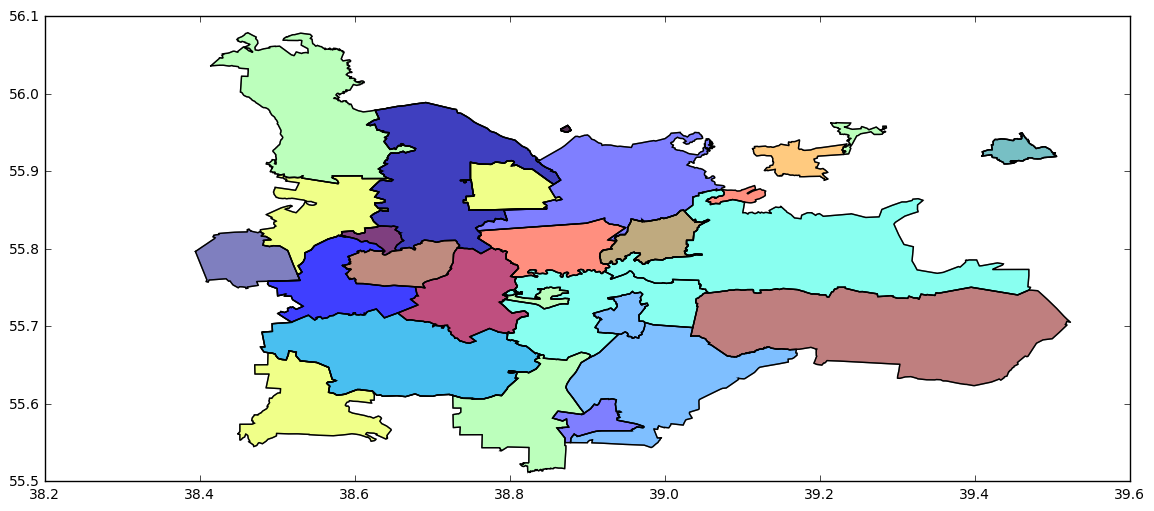

In [75]:
# Setup the size of the image
# matplotlib.rcParams['figure.figsize'] = (14, 14)
plt.figure(figsize=(14,14))
# Print map
df_admin.plot()
plt.show()

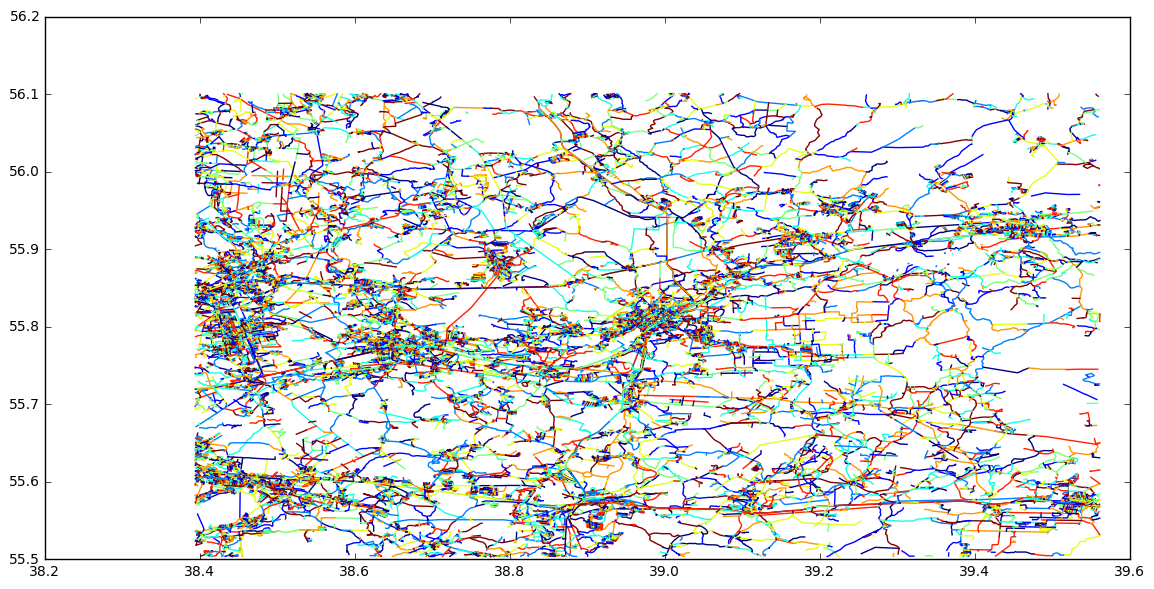

In [65]:
df_roads.plot()
plt.show()

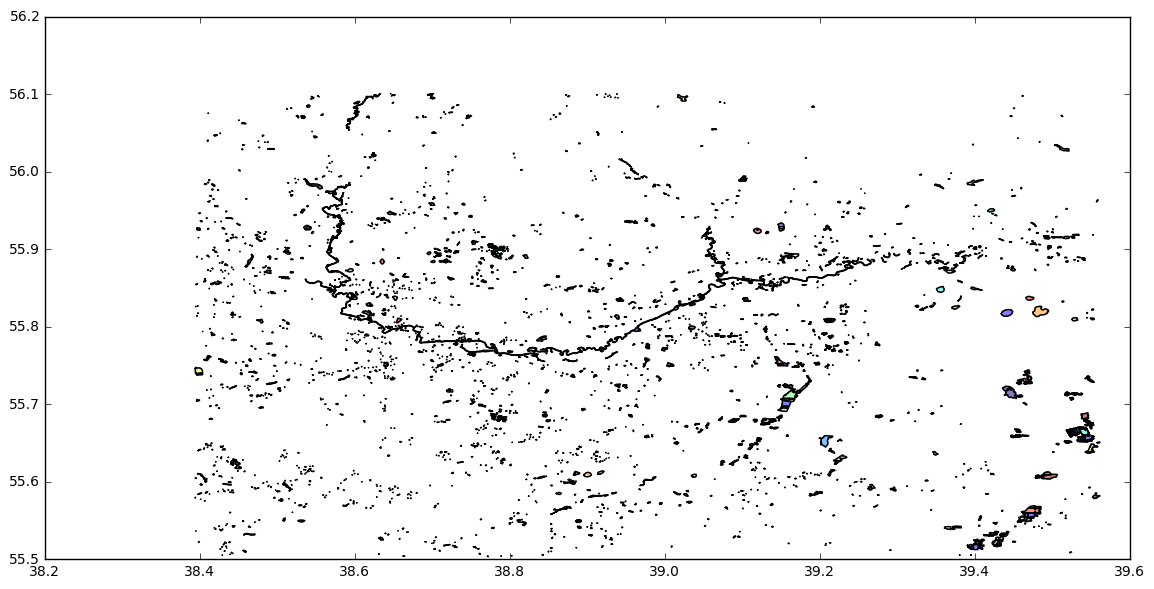

In [67]:
df_waterareas.plot()
plt.show()

##### 1.7 Shapefiles

##### For displaying the data in shapefiles it's possible to apply the package "basemap". As an example you can see the map of administrative borders, roads and water areas.

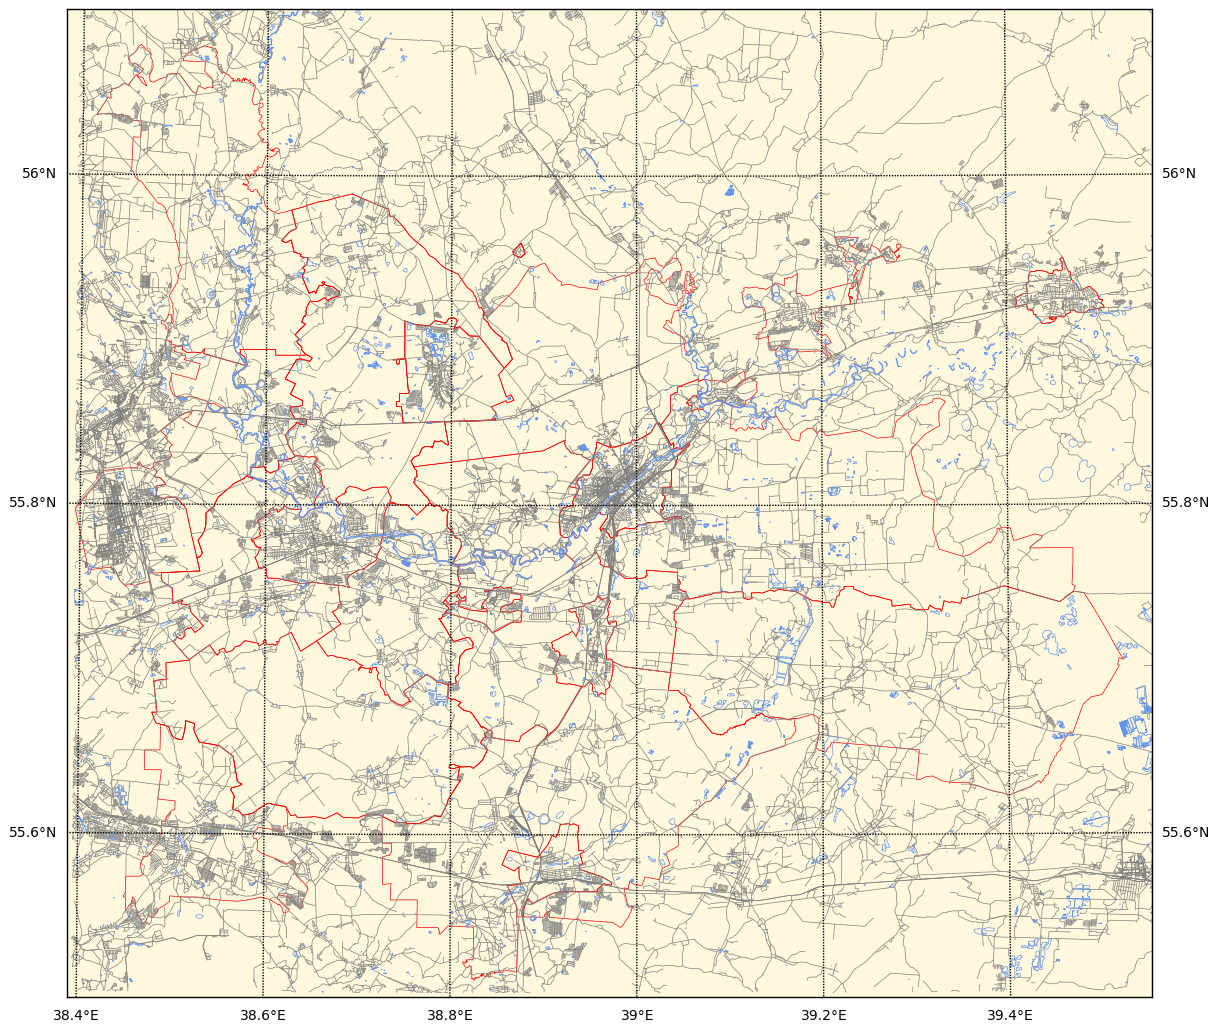

In [68]:
# Setup the size of the image
plt.figure(figsize=(14,14))
# Setup the colors for surfaces
water = 'lightskyblue'
earth = 'cornsilk'
# Create a map
mm = Basemap(llcrnrlon=38.39, llcrnrlat=55.50, urcrnrlon=39.56, urcrnrlat=56.10, ellps='WGS84', resolution='i', projection='cass', lat_0 = 55.7986, lon_0 = 38.9754)
# Variables for drawing map components
coast = mm.drawcoastlines()
rivers = mm.drawrivers(color=water, linewidth=1)
continents = mm.fillcontinents(color=earth,lake_color=water)
bound= mm.drawmapboundary(fill_color=water)
countries = mm.drawcountries()
merid = mm.drawmeridians(np.arange(-180, 180, 0.2), labels=[False, False, False, True])
parall = mm.drawparallels(np.arange(0, 80, 0.2), labels=[True, True, False, False])
# Read shapefiles
mm.readshapefile('/Users/olgabelitskaya/projects/nd002/Data_Analyst_ND_Project3/moscow_region.imposm-shapefiles/moscow_region_osm_admin', name='admin', drawbounds=True, color='red')
mm.readshapefile('/Users/olgabelitskaya/projects/nd002/Data_Analyst_ND_Project3/moscow_region.imposm-shapefiles/moscow_region_osm_roads', name='roads', drawbounds=True, color='grey')
mm.readshapefile('/Users/olgabelitskaya/projects/nd002/Data_Analyst_ND_Project3/moscow_region.imposm-shapefiles/moscow_region_osm_waterareas', name='waterareas', drawbounds=True, color='cornflowerblue')
# Display the map
plt.show()

##### 1.8 CSV files

##### Applying the special function (§ 0.3) I created the csv files from the sample.osm the moscow_region.osm.

In [83]:
# Setup variables for extracting csv files (sample)
OSM_PATH = file5

NODES_PATH = "nodes0.csv"
NODE_TAGS_PATH = "nodes_tags0.csv"
WAYS_PATH = "ways0.csv"
WAY_NODES_PATH = "ways_nodes0.csv"
WAY_TAGS_PATH = "ways_tags0.csv"

In [170]:
# Extract data from sample.osm as csv files
# process_map_csv(OSM_PATH, validate=True)

In [85]:
# Setup variables for extracting csv files (dataset)
OSM_PATH = file1

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

In [169]:
# Extract data from the dataset in the .osm format as csv files
# process_map_csv(OSM_PATH, validate=False)

##### 1.9 Json file

##### Applying the special function (§ 0.3) I created the moscow_region.osm.json from the moscow_region.osm file.

In [171]:
# Extract data from the dataset in the .osm format as json files
data1 = process_map(file1)

In [172]:
# Setup the variable for the .json file
file7 = filedir1 + 'moscow_region.osm.json'

In [173]:
# Get size of the .json file
os.path.getsize(file7)

281607059

### 2. Data

##### Let's discover the data in .osm files in details.

##### 2.1 Tags

In [91]:
# Count tags
count_tags(file1)

defaultdict(int,
            {'bounds': 1,
             'member': 12002,
             'nd': 1451696,
             'node': 1120539,
             'osm': 1,
             'relation': 2286,
             'tag': 264103,
             'way': 162947})

##### 2.2 Users

In [92]:
# Count users
users1 = process_map_users(file1)

In [93]:
# Display number of users
print "Number of users -", len(users1)
# Display example of the user list
list(users1)[41:50]

Number of users - 681


['Haduxa',
 'NikolaTarasov155',
 'Z440',
 'etajin',
 'ivvanko',
 'Dr Mueller',
 'NorthmanMSU',
 'AlexTheTux',
 'vdmit']

##### 2.3 Keys

In [149]:
# Count keys by types
process_map_keys(file1)

{'lower': 223976, 'lower_colon': 39687, 'other': 251, 'problemchars': 189}

##### 2.4 Number of street addresses

In [97]:
# Count street addresses
street_number(file1)

6746

##### 2. 5 Places

In [148]:
# Count places by types
process_map_places(file1)

{'city': 3, 'hamlet': 298, 'other': 63, 'town': 13, 'village': 130}

##### 2.6 Names in English

In [114]:
# Count names in english with values
english_names1 = process_map_names(file1)

In [122]:
#Display english names
print english_names1

(78, set(['Fryazevo', 'Elektrostal', 'Shaturtorf', 'Fenino', 'Pavlovsky Posad', 'Gorki', 'Staroye Titovo', 'Sanino', '821th Main Space Intelligence Centre', 'Selivanikha', 'Ponarino', 'Gzhel', 'Guslitsa', 'Gzhelskogo kirpichnogo zavoda', 'Konyashino', 'Troshkovo', 'Avsyunino', 'Saputnoye', 'Minino', 'Likino-Dulyovo', "McDonald's", 'Pokrov', 'Elektrogorsk', 'Orekhovo-Zuevo', 'Chernogolovka', 'Drezna', 'Fomino', 'Svorkovo', 'Avsjunino', 'Znamya', 'Gorbuny', 'Noginsk', 'Circle K', 'Znamenskoye', 'Gribanino', 'Petrushino', 'Road to Belyvsiye Skity', 'Ignatyevo', 'Petushki', 'Rodionovo', 'derevnya Dorokhovo', 'Glebovo', 'Dvornikovo', 'Subway', 'Davydovo', 'Krupino', 'Magnit', 'Kalitino', 'Fryazevo Railway Station', '55 km', 'Petrovskoye', 'Dubrovo', 'Shatura', 'Novoye Titovo', 'Levoshevo', 'Framing workshop, Art salon "Manufactura"', 'Kuzyayevo', 'Kurovskoye', 'Koreshkova street', 'Zhilino', 'Mistsevo', 'Krasnyy Luch']))


##### On the map we can find the names in English. As you can see, they are not only the names of settlements but also the names of infrastructure objects. The next obvious conclusion about it: not all the cities, towns, hamlets and villages on the map have names in English.

##### 2.7 Postal Codes

In [121]:
# Display zip codes
print zip_codes(file1)

(1503, set(['142436', '142515', '142516', '142432', '142411', '142670', '142602', '142438', '142439', '142620', '142530', 'RU', '142672', '140165', '140145', '144000', '140703', '142641', '142502', '142640', '142642', '142645', '142409', '142621', '142646', '142649', '601130', '601010', '142612', '142664', '144005', '142608', '142613', '144004', '140221', '601143', '142601', '142600', '142603', '140712', '142520', '142507', '142504', '142505', '144009', '140704', '142500', '142408', '142542', '144001', '144007', '142541', '142403', '142402', '142401', '142400', '142605', '142660', '144010', '144002', '144006', '140150', '601144', '140155', '601103', '142651', '142647', '601105', '601125', '601127', '601120', '142671', '601122', '601123', '142407', '142663', '142636', '142506', '142631', '142632', '142633', '601109', '142635', '140700', '142611']))


###### According to reference information (https://en.wikipedia.org/wiki/List_of_postal_codes_in_Russia) the postal codes for Moscow Region begin with 140, 141, 142, 144, for Vladimir region - with 600, 601, 602. This section of map is located on the territory of these two regions.

In [115]:
# Audit zip codes
postcode1 = process_map_postcodes(file1)

In [116]:
# Display number of unexpected zip codes
postcode1['RU']

12

###### There are 12 notations in the dataset with wrong postcodes. 

### 3. CSV & SQL

### 4. JSON & Mongo DB

### 5. Problems and errors

### 6. Data Overview

### 7. Conclusion

### 8. Addition